<a href="https://colab.research.google.com/github/gracchen/bionics-lab-hand-plots/blob/main/plots.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Findings:
I evaluated the normalized ranges of every csv and counted how many had the x dominate (have the greatest change out of the other axis) for the thumb, how many for y, how many for z, and repeated for the index, counting multiple for the same file if they roughly tied. Then I just pick the axis for thumb that dominated the most compared to the other axis and same for thumb, for all 8 rows below to see which axis dominated.


While the Thumb's dominating angle depended on the hand and the test, the index was overwhelmingly dominated by the z axis regardless of the hand or the test. This suggests that the motion of curling the index finger inwards to the palm is the motion along the z-axis and also the motion that all tests seem to mainly rely on for completion. Meanwhile, the thumb, which is the main tool for human hand dexterity and grasping, is tested in all three axis depending on the test. Many times the principle angle of the thumb was tied between two and almost all three axis for many of the tests. This method could be automated in code to compare exact quantitative ranges and give a more precise answer, but it would ignore the fact that two axis have almost the same range with a negliglbe point-one etc range difference.


| Test | Hand | Thmb x-dom | Thmb y-dom | Thmb z-dom | Indx x-dom | Indx y-dom | Indx z-dom | Overall Thmb dom | Overall Indx dom |
| --- | --- | --- | --- | --- | --- | --- | --- | --- | --- |
| Mass Flexion | Left | 4 | 0 | 1 | 0 | 0 | 4 | x | z
| Mass Flexion | Right | 4 | 4 | 1 | 0 | 0 | 6 | xy | z
| Mass Extension | Left | 3 | 1 | 3 | 0 | 0 | 3 | xz | z
| Mass Extension | Right | 2 | 2 | 1 | 0 | 0 | 2 | xy | z
| Hook Grasp | Left | 3 | 0 | 0 | 0 | 0 | 3 | x | z
| Hook Grasp | Right | 1 | 2 | 0 | 0 | 0 | 2 | y | z
| Thumb Adduction | Left | 1 | 0 | 1 | 0 | 0 | 1 | xz | z
| Thumb Adduction | Right | 3 | 0 | 3 | 0 | 0 | 4 | xz | z



# Method
Below is the code to smooth (remove jumps), normalize (start at 0 degrees and use same y-range for sets of x,y,z plots), and plot all of the csv files for the first four hand tests. All the plots can be found in this google drive directory in the plots folder, either raw or normalized, sorted by test.

In [ ]:
```````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````from google.colab import drive
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', None)
import matplotlib.pyplot as plt

drive.mount('/content/drive')

folder = '/content/drive/My Drive/Bionics Lab Research/Hand Sensors_Data Processing/'
data_path = folder + 'HandSensorData_05242024/'

Mounted at /content/drive


## Helper Functions to smooth and plot:

In [ ]:
# smoothen and plot:

def smooth_data(MotionData, col_name):
    """
    Takes the file dataframe and desired column to smooth (i.e. thumb01x)
    iterates through each element of the column (angle data) and smooths any
    jumps in the data with a constant being the difference between before and
    after the jump. Comment out the second last line to disable normalizing.
    """
    data = MotionData[col_name].copy()  # Create a copy of the column data
    i = 1
    while i < len(data):
      if abs(data[i-1] - data[i]) > 100:  # Jump detected
        b4_jmp = i - 1
        constant = data[b4_jmp] - data[b4_jmp + 1]
        while i < len(data) and abs(data[b4_jmp] - data[i]) > 100:  # Jump detected
          data[i] += constant
          i += 1
      i += 1
    # normalize by moving everything so first data point at 0 degrees
    data -= data[0]
    MotionData[col_name] = data  # Update the column in the original DataFrame

def smooth_file(file_name):
    """
    repeats smoothening for all desired columns (3 axes of 2 measured fingers)
    """
    MotionData = pd.read_csv(data_path+file_name)
    for finger in ['Thumb', 'Index']:
      for axis in ['x', 'y', 'z']:
        smooth_data(MotionData, finger+'01'+axis)
    return MotionData


def graph_file(file_name, test_name, save_path = None, smooth=True):
    """
    generates smoothened plots of x,y,z for one csv file given path, test name,
    hand (left or right). If save_path defined, will save the plot as image in
    plots folder, otherwise will display it.
    """
    MotionData = None
    if smooth:
      MotionData = smooth_file(file_name)  # Smooth the data first
    else:
      MotionData = pd.read_csv(data_path+file_name)
    timespan = np.linspace(0,MotionData.Index01x.size,MotionData.Index01x.size)
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 20)) # increased height
    # get min and max across all important columns in this file:
    max_range = max(
        max(MotionData['Index01x'].tolist() + MotionData['Thumb01x'].tolist()) - min(MotionData['Index01x'].tolist() + MotionData['Thumb01x'].tolist()),
        max(MotionData['Index01y'].tolist() + MotionData['Thumb01y'].tolist()) - min(MotionData['Index01y'].tolist() + MotionData['Thumb01y'].tolist()),
        max(MotionData['Index01z'].tolist() + MotionData['Thumb01z'].tolist()) - min(MotionData['Index01z'].tolist() + MotionData['Thumb01z'].tolist())
    )

    # avoid scrolling if displaying one plot:
    from IPython.display import Javascript
    display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 5000})'''))

    # generate the 3 plots as one image, aligned via x-axis (time)
    for axis,plt_id in zip(['x','y','z'], [ax1,ax2,ax3]):
      plt_id.plot(timespan, MotionData['Index01'+axis], label = 'index1' + axis)
      plt_id.plot(timespan, MotionData['Thumb01'+axis], label = 'thumb1' + axis)
      plt_id.legend();
      plt_id.set(xlabel ='time', ylabel = 'degrees')
      plt_id.set_title(test_name + ' ' + hand + ' Hand ' + axis + '-axis')
      plt_id.set_ylim(min(MotionData['Index01'+axis].tolist() + MotionData['Thumb01'+axis].tolist()), min(MotionData['Index01'+axis].tolist() + MotionData['Thumb01'+axis].tolist())+max_range)

    # show or save the image:
    if save_path is not None:
      file_prefix = os.path.splitext(file_name)[0]  # Get the filename without extension
      save_file_path = os.path.join(save_path, f"{file_prefix}.png")
      print(f"saving to {save_file_path}")
      plt_id.figure.savefig(save_file_path)
      plt.close()  # to avoid showing a bajillion plots
    else:
      plt.show()

In [ ]:
# grab all the csvs and divide into filenames[test#][right/left] dictionary

import os
file_list = os.listdir(data_path)

filenames = {}
testnames = ["MassFlexion", "MassExtension", "HookGrasp", "ThumbAdduction"]
for testname, testno in zip(testnames, range(0,4)):
    filenames[testno] = {'right': [filename for filename in file_list if testname in filename and 'Right' in filename],
                        'left': [filename for filename in file_list if testname in filename and 'Left' in filename]}

for testno, files in filenames.items():
    print(f"Test {testno}:")
    for hand, filenames_list in files.items():
        print(f"  {hand.capitalize()} hand:")
        for filename in filenames_list:
            print(f"    {filename}")

Test 0:
  Right hand:
    RightHand_05_24_2024_18_07_56_1MassFlexion.csv
    RightHand_05_24_2024_18_14_06_1MassFlexion.csv
    RightHand_05_24_2024_18_14_26_1MassFlexion.csv
    RightHand_05_24_2024_18_14_31_1MassFlexion.csv
    RightHand_05_24_2024_18_15_36_1MassFlexion.csv
    RightHand_05_24_2024_18_15_41_1MassFlexion.csv
  Left hand:
    LeftHand_05_24_2024_18_23_43_1MassFlexion.csv
    LeftHand_05_24_2024_18_23_51_1MassFlexion.csv
    LeftHand_05_24_2024_18_23_59_1MassFlexion.csv
    LeftHand_05_24_2024_18_26_15_1MassFlexion.csv
Test 1:
  Right hand:
    RightHand_05_24_2024_18_16_26_2MassExtension.csv
    RightHand_05_24_2024_18_16_30_2MassExtension.csv
  Left hand:
    LeftHand_05_24_2024_18_24_17_2MassExtension.csv
    LeftHand_05_24_2024_18_24_23_2MassExtension.csv
    LeftHand_05_24_2024_18_26_27_2MassExtension.csv
Test 2:
  Right hand:
    RightHand_05_24_2024_18_16_59_3HookGrasp.csv
    RightHand_05_24_2024_18_17_14_3HookGrasp.csv
  Left hand:
    LeftHand_05_24_2024_18_24

## Generate Plots and save to folder:

<IPython.core.display.Javascript object>

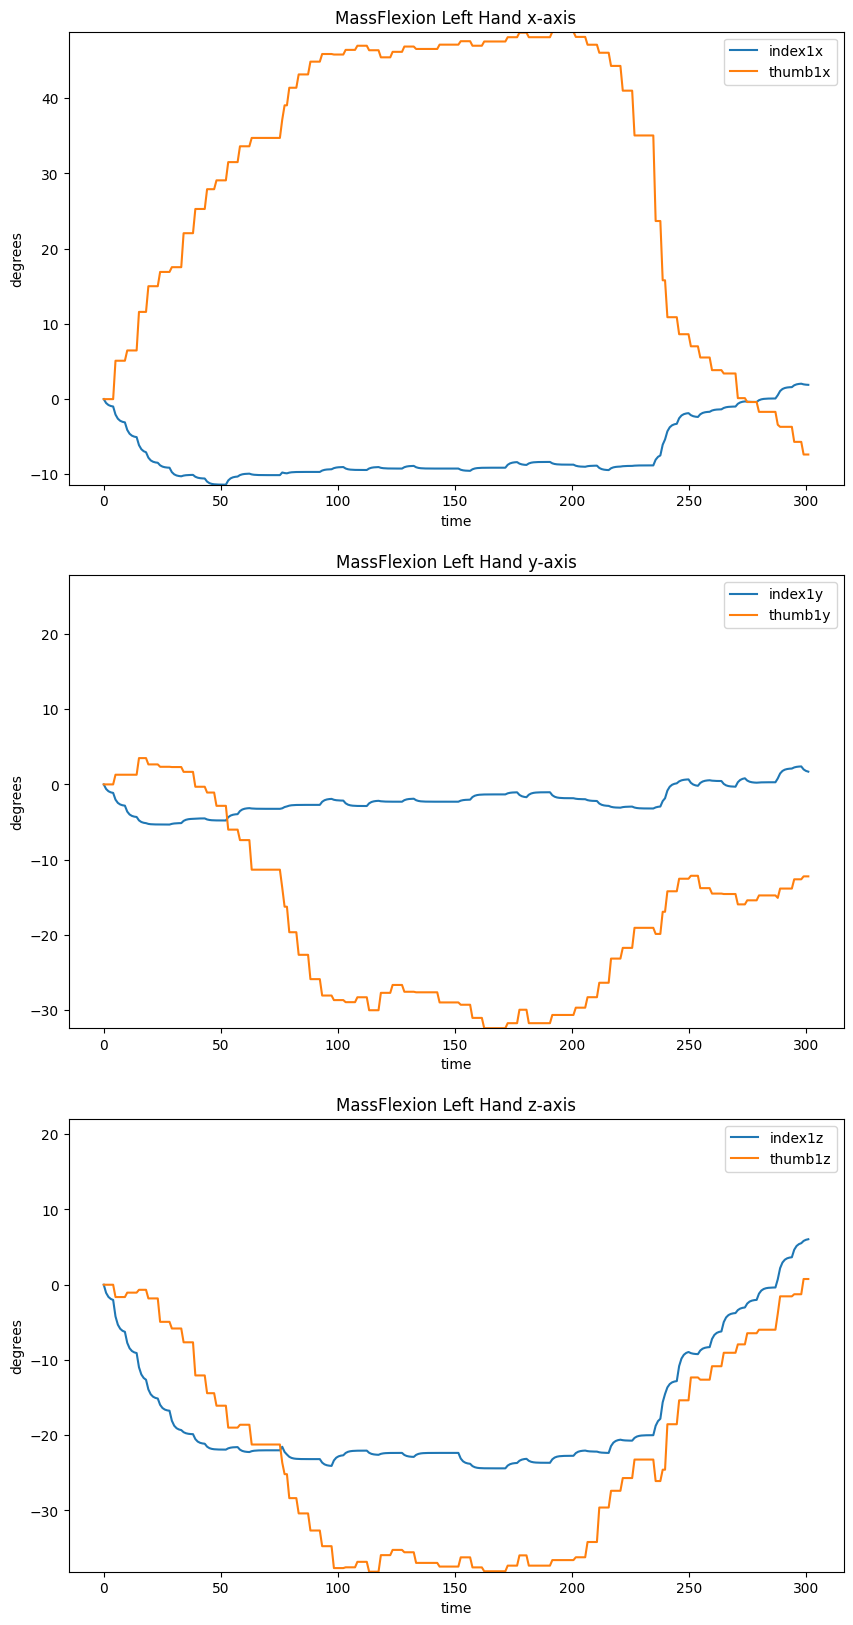

In [ ]:
# example plot:
graph_file('LeftHand_05_24_2024_18_23_51_1MassFlexion.csv', 'MassFlexion', "Left")

In [ ]:
# generate and save batch of all plots:
for testno in range(4):
    for hand in ['right', 'left']:
        for file_name in filenames[testno][hand]:
            save_folder = os.path.join(folder, f"plots/normalized/Test {testno}: {testnames[testno]}")
            os.makedirs(save_folder, exist_ok=True)
            graph_file(file_name, testnames[testno], hand.capitalize(), save_path=save_folder)
            #print(f"graph_file({file_name}, {testnames[testno]}, {hand.capitalize()}, {save_folder})")

<IPython.core.display.Javascript object>

saving to /content/drive/My Drive/Bionics Lab Research/Hand Sensors_Data Processing/plots/normalized/Test 0: MassFlexion/RightHand_05_24_2024_18_07_56_1MassFlexion.png


<IPython.core.display.Javascript object>

saving to /content/drive/My Drive/Bionics Lab Research/Hand Sensors_Data Processing/plots/normalized/Test 0: MassFlexion/RightHand_05_24_2024_18_14_06_1MassFlexion.png


<IPython.core.display.Javascript object>

saving to /content/drive/My Drive/Bionics Lab Research/Hand Sensors_Data Processing/plots/normalized/Test 0: MassFlexion/RightHand_05_24_2024_18_14_26_1MassFlexion.png


<IPython.core.display.Javascript object>

saving to /content/drive/My Drive/Bionics Lab Research/Hand Sensors_Data Processing/plots/normalized/Test 0: MassFlexion/RightHand_05_24_2024_18_14_31_1MassFlexion.png


<IPython.core.display.Javascript object>

saving to /content/drive/My Drive/Bionics Lab Research/Hand Sensors_Data Processing/plots/normalized/Test 0: MassFlexion/RightHand_05_24_2024_18_15_36_1MassFlexion.png


<IPython.core.display.Javascript object>

saving to /content/drive/My Drive/Bionics Lab Research/Hand Sensors_Data Processing/plots/normalized/Test 0: MassFlexion/RightHand_05_24_2024_18_15_41_1MassFlexion.png


<IPython.core.display.Javascript object>

saving to /content/drive/My Drive/Bionics Lab Research/Hand Sensors_Data Processing/plots/normalized/Test 0: MassFlexion/LeftHand_05_24_2024_18_23_43_1MassFlexion.png


<IPython.core.display.Javascript object>

saving to /content/drive/My Drive/Bionics Lab Research/Hand Sensors_Data Processing/plots/normalized/Test 0: MassFlexion/LeftHand_05_24_2024_18_23_51_1MassFlexion.png


<IPython.core.display.Javascript object>

saving to /content/drive/My Drive/Bionics Lab Research/Hand Sensors_Data Processing/plots/normalized/Test 0: MassFlexion/LeftHand_05_24_2024_18_23_59_1MassFlexion.png


<IPython.core.display.Javascript object>

saving to /content/drive/My Drive/Bionics Lab Research/Hand Sensors_Data Processing/plots/normalized/Test 0: MassFlexion/LeftHand_05_24_2024_18_26_15_1MassFlexion.png


<IPython.core.display.Javascript object>

saving to /content/drive/My Drive/Bionics Lab Research/Hand Sensors_Data Processing/plots/normalized/Test 1: MassExtension/RightHand_05_24_2024_18_16_26_2MassExtension.png


<IPython.core.display.Javascript object>

saving to /content/drive/My Drive/Bionics Lab Research/Hand Sensors_Data Processing/plots/normalized/Test 1: MassExtension/RightHand_05_24_2024_18_16_30_2MassExtension.png


<IPython.core.display.Javascript object>

saving to /content/drive/My Drive/Bionics Lab Research/Hand Sensors_Data Processing/plots/normalized/Test 1: MassExtension/LeftHand_05_24_2024_18_24_17_2MassExtension.png


<IPython.core.display.Javascript object>

saving to /content/drive/My Drive/Bionics Lab Research/Hand Sensors_Data Processing/plots/normalized/Test 1: MassExtension/LeftHand_05_24_2024_18_24_23_2MassExtension.png


<IPython.core.display.Javascript object>

saving to /content/drive/My Drive/Bionics Lab Research/Hand Sensors_Data Processing/plots/normalized/Test 1: MassExtension/LeftHand_05_24_2024_18_26_27_2MassExtension.png


<IPython.core.display.Javascript object>

saving to /content/drive/My Drive/Bionics Lab Research/Hand Sensors_Data Processing/plots/normalized/Test 2: HookGrasp/RightHand_05_24_2024_18_16_59_3HookGrasp.png


<IPython.core.display.Javascript object>

saving to /content/drive/My Drive/Bionics Lab Research/Hand Sensors_Data Processing/plots/normalized/Test 2: HookGrasp/RightHand_05_24_2024_18_17_14_3HookGrasp.png


<IPython.core.display.Javascript object>

saving to /content/drive/My Drive/Bionics Lab Research/Hand Sensors_Data Processing/plots/normalized/Test 2: HookGrasp/LeftHand_05_24_2024_18_24_40_3HookGrasp.png


<IPython.core.display.Javascript object>

saving to /content/drive/My Drive/Bionics Lab Research/Hand Sensors_Data Processing/plots/normalized/Test 2: HookGrasp/LeftHand_05_24_2024_18_24_51_3HookGrasp.png


<IPython.core.display.Javascript object>

saving to /content/drive/My Drive/Bionics Lab Research/Hand Sensors_Data Processing/plots/normalized/Test 2: HookGrasp/LeftHand_05_24_2024_18_26_51_3HookGrasp.png


<IPython.core.display.Javascript object>

saving to /content/drive/My Drive/Bionics Lab Research/Hand Sensors_Data Processing/plots/normalized/Test 3: ThumbAdduction/RightHand_05_24_2024_18_17_43_4ThumbAdduction.png


<IPython.core.display.Javascript object>

saving to /content/drive/My Drive/Bionics Lab Research/Hand Sensors_Data Processing/plots/normalized/Test 3: ThumbAdduction/RightHand_05_24_2024_18_18_04_4ThumbAdduction.png


<IPython.core.display.Javascript object>

saving to /content/drive/My Drive/Bionics Lab Research/Hand Sensors_Data Processing/plots/normalized/Test 3: ThumbAdduction/RightHand_05_24_2024_18_18_30_4ThumbAdduction.png


<IPython.core.display.Javascript object>

saving to /content/drive/My Drive/Bionics Lab Research/Hand Sensors_Data Processing/plots/normalized/Test 3: ThumbAdduction/RightHand_05_24_2024_18_18_45_4ThumbAdduction.png


<IPython.core.display.Javascript object>

saving to /content/drive/My Drive/Bionics Lab Research/Hand Sensors_Data Processing/plots/normalized/Test 3: ThumbAdduction/LeftHand_05_24_2024_18_27_07_4ThumbAdduction.png
